<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

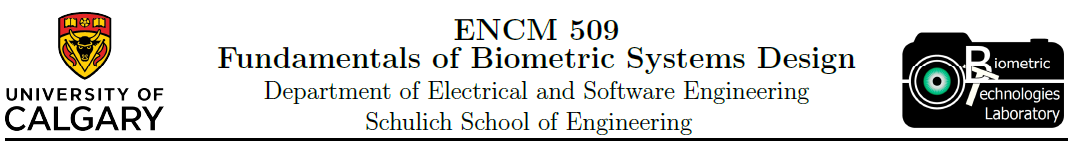

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>


* Team member - Abid Al Labib 
    - UCID: 30070079
* Team member - Madhu Selvaraj
    - UCID: 30061979
    

## Introduction:
In this lab we became familiar with face feature extraction and classification using Principal Component Analysis (PCA), Euclidean Distance for face matching, and a KNN classifier. We evaluated the distances of various types of probe faces when compared with faces in the gallery, and then used confusion matrices to analyze how varying differing PCA and KNN parameters affects the accuracy of classification. 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Exercise 1

In [52]:
# M could be large (for example, 16: 8 of yours and 8 of a friend)
# for At&T dataset there are 10 faces per subject. 
# However, we are going to load only the first 9
# the 10th image will be used to compare later on.
M =  9 #Number of images in training set

#image normalization
# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

#loading image to get dimensions
img = imread('ATT dataset/s1/' + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304


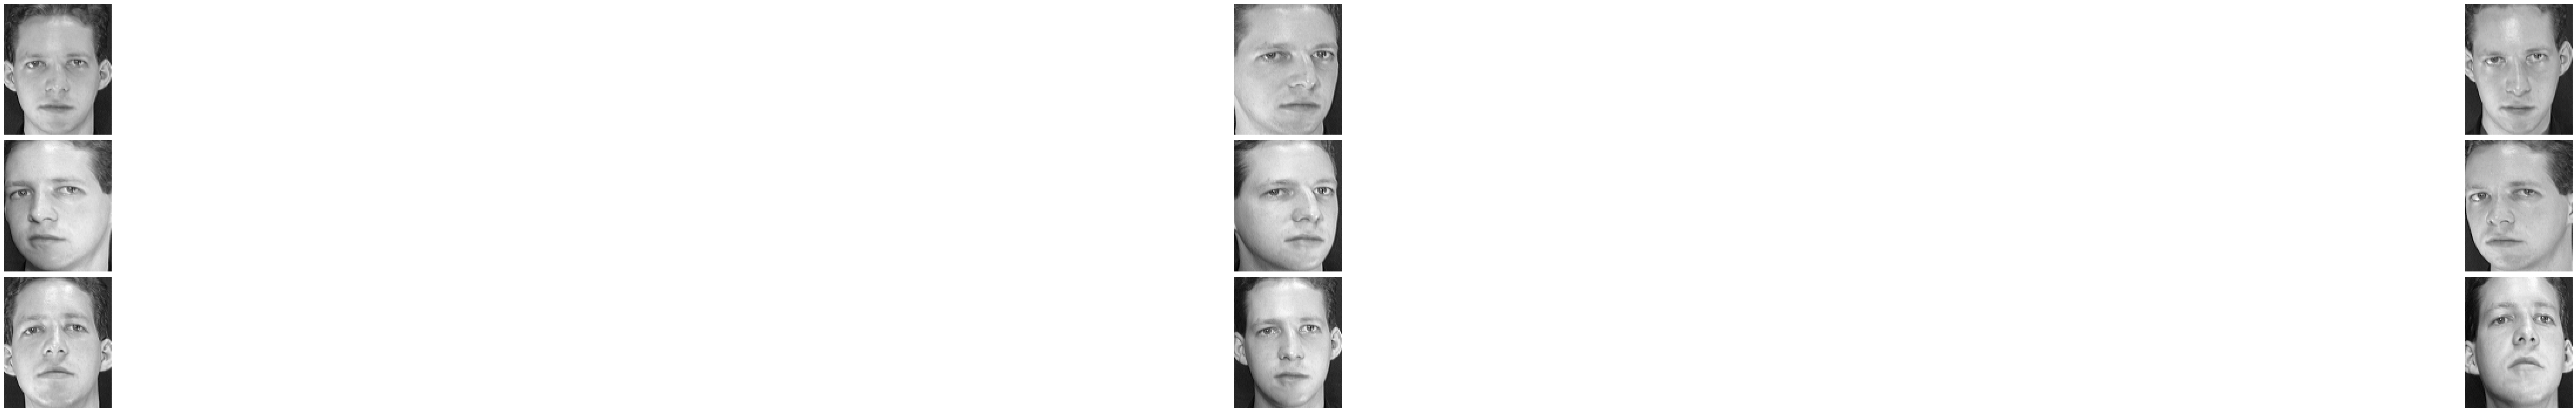

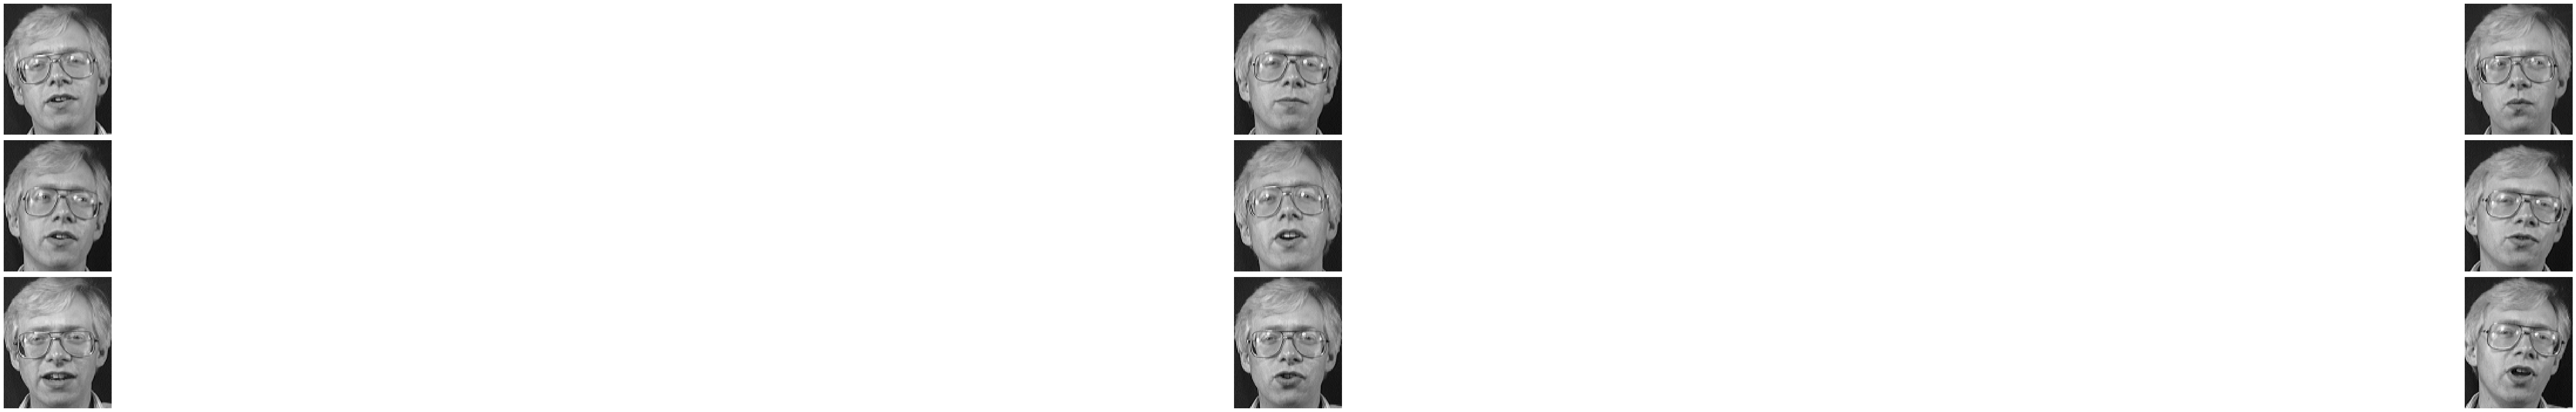

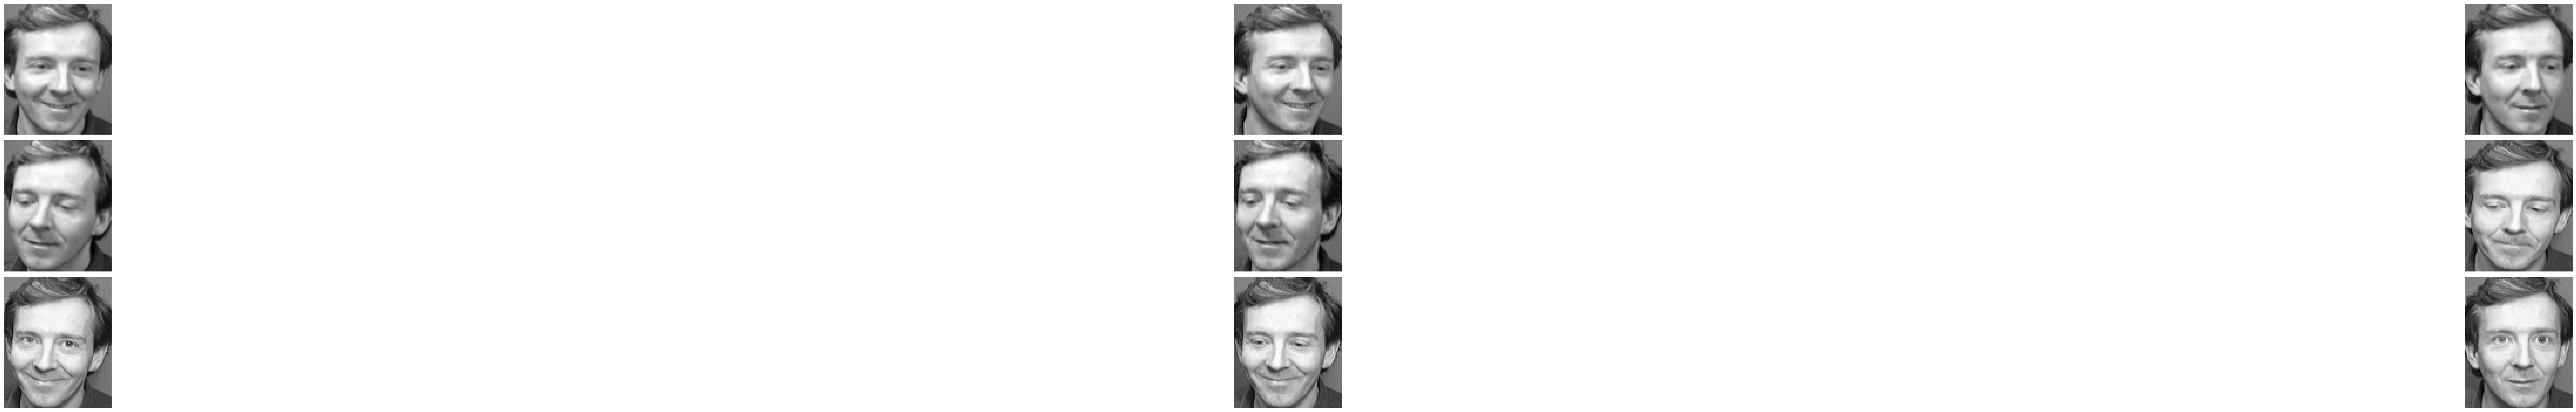

In [53]:
#storing all 27 faces into one gallery, first 9 images from subjects 1, 2, and 3

S = np.zeros((irow*icol, M*3)) # img matrix

#loading the gallery images
for subject in range(1,4):
    path = f'ATT dataset/s{subject}/'
    img = imread(path + '1.pgm', as_gray=True)

    # get the number of rows (irow) and columns (icol). 
    # these values must to be the same for all images
    irow, icol = img.shape

    # allocation of vector that will have all images


    plt.figure(figsize=(100,100))
    for i in range(M,-1,-1):
        if i==0:
            i=i+1
        img = imread(path + '{}.pgm'.format(i), as_gray=True)

        plt.subplot(27,3,i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # reshape(img',irow*icol,1); 
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        index = (subject*9) - i
        S[:,index] = temp[:,0] 
    # after finishing the sequence, S is a N1*N2xM matrix 

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

##### viewing the normalized images

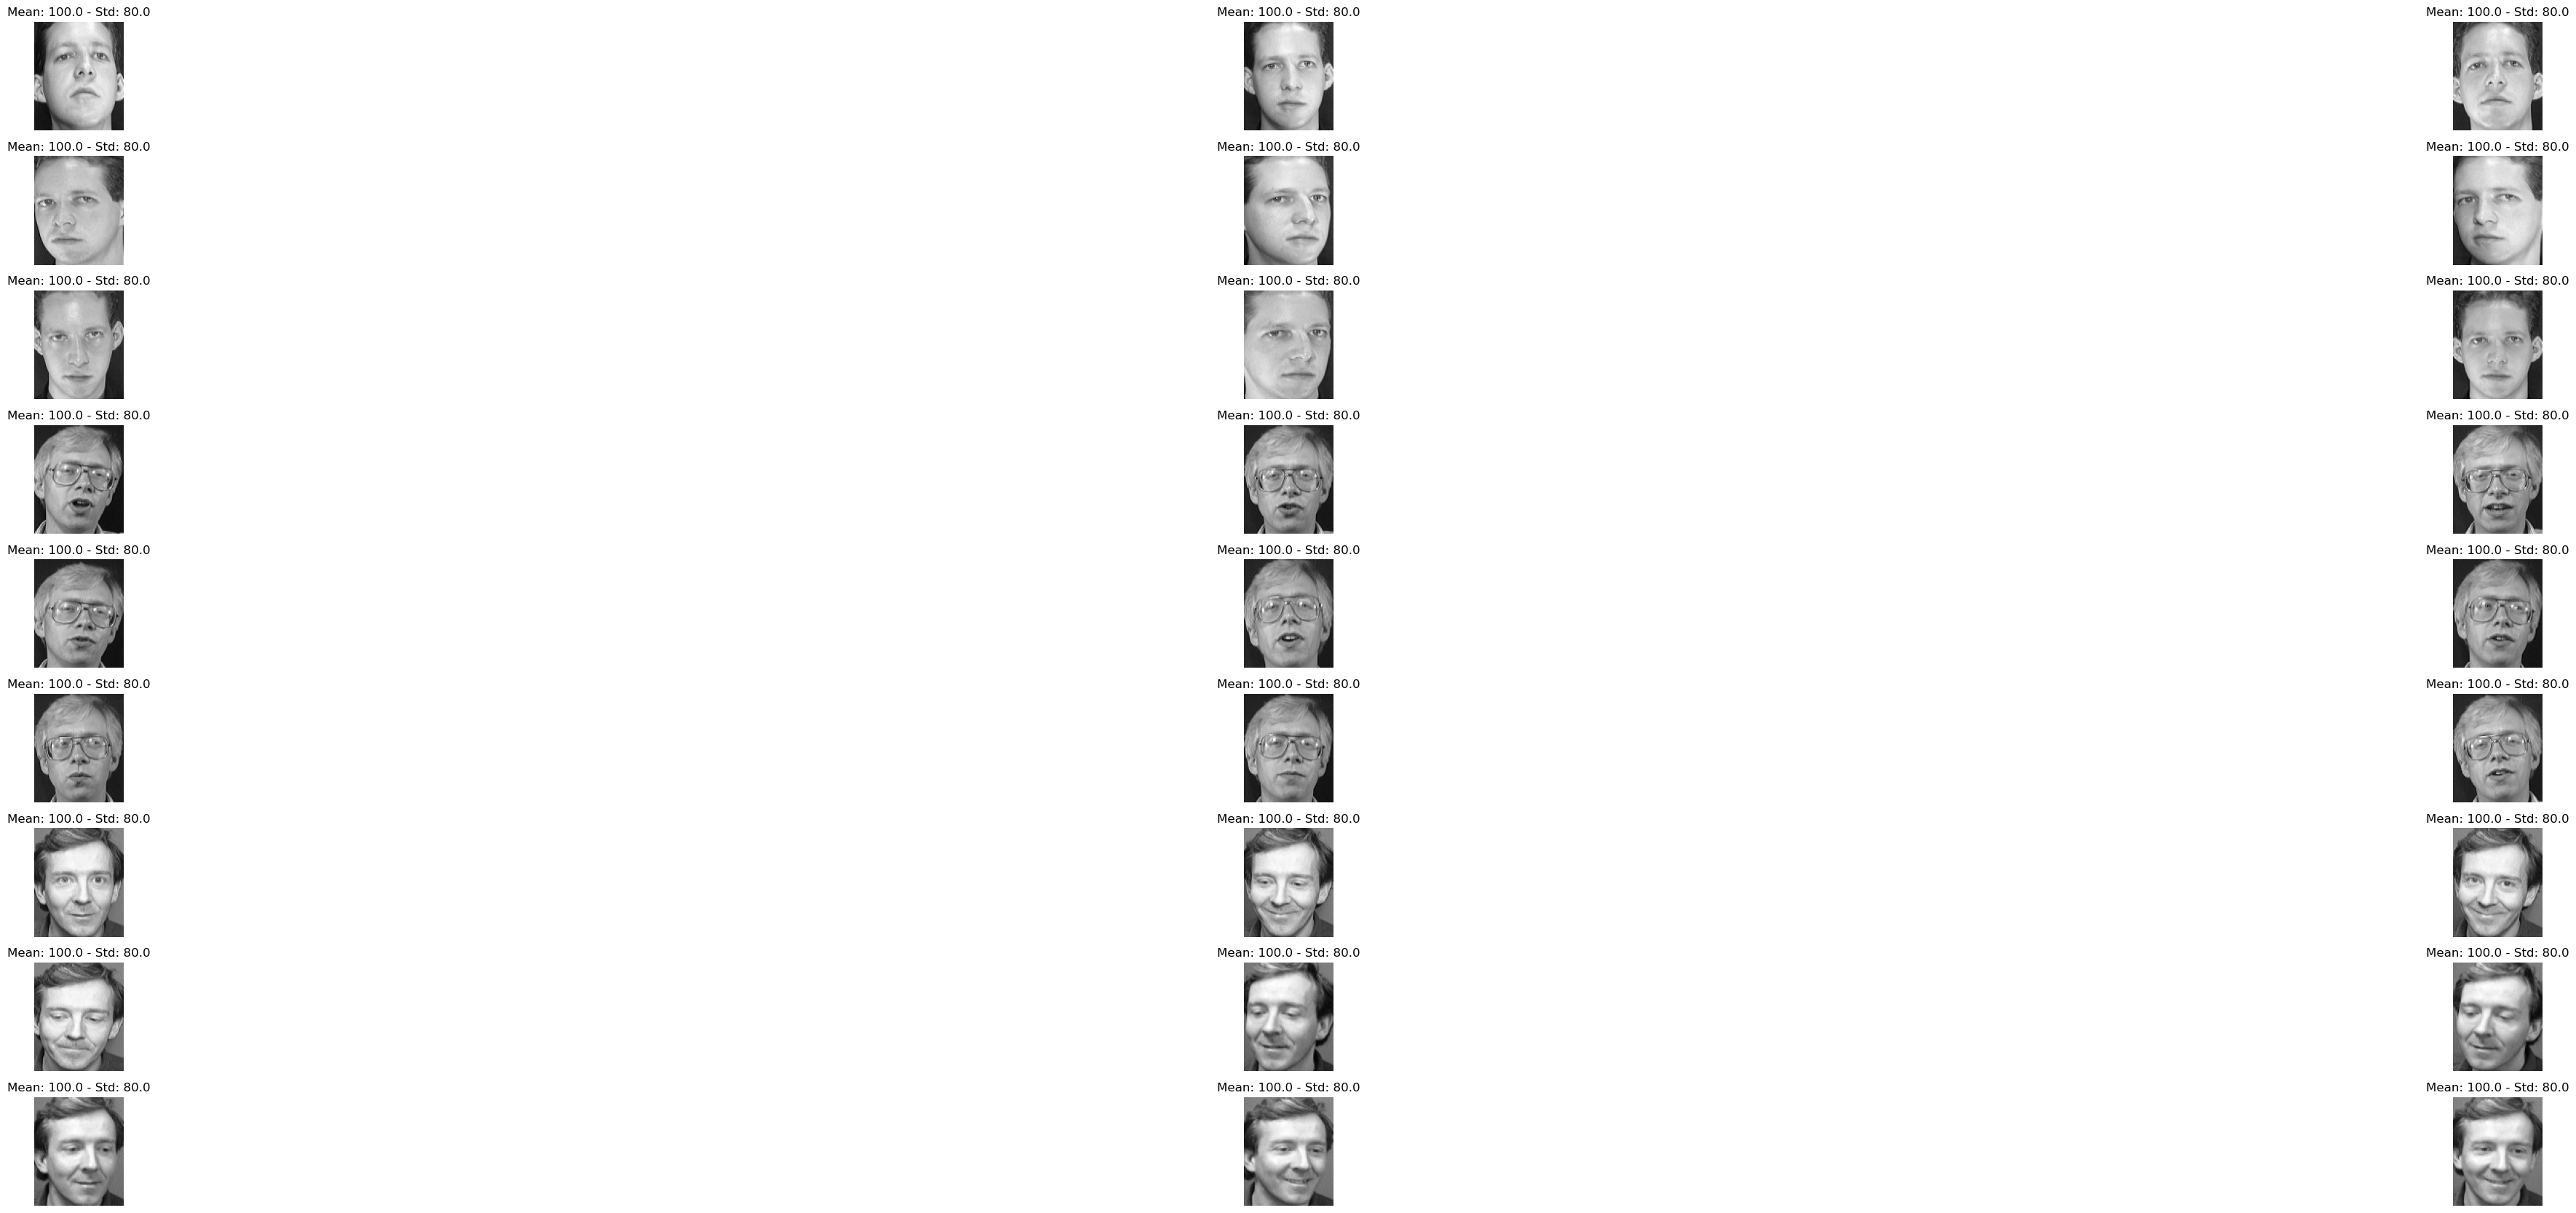

In [54]:
plt.figure(figsize=(50,50))
for i in range(27):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(27,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

##### mean image

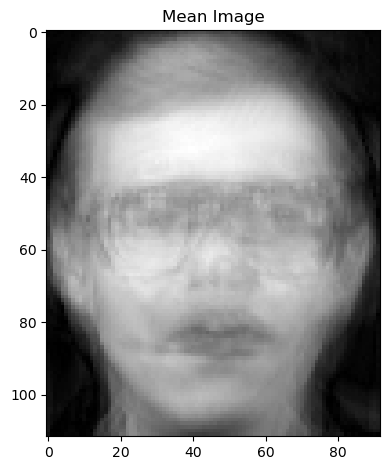

In [55]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

##### Creating covariance matrix  L

In [56]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

##### Sort and eliminate zero eigenvalue

In [57]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

C:\Users\madhu\AppData\Local\Temp\ipykernel_16468\184907035.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


#### Normalization of eigenvectors

In [58]:
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

#### Showing eigenfaces

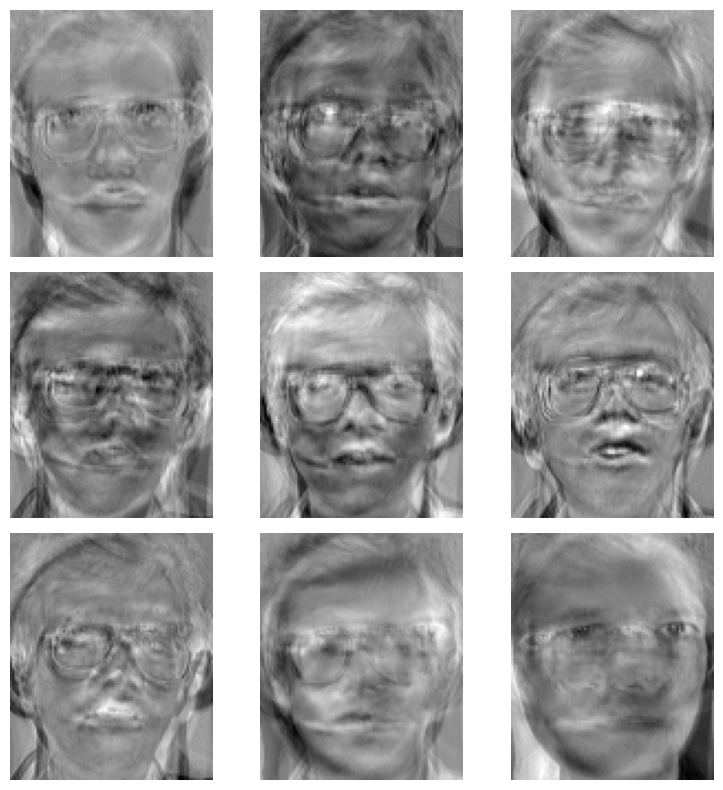

In [59]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

#### Find the weight of each face in the training set

In [60]:
omega = np.zeros((27,27))
WW = np.zeros((27,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

### Acquisition of probe image: 10th image of each of the three subjects in the dataset

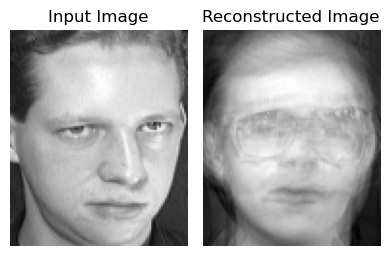

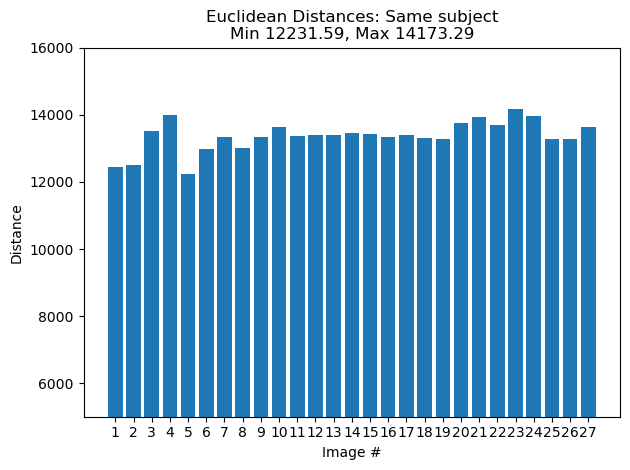

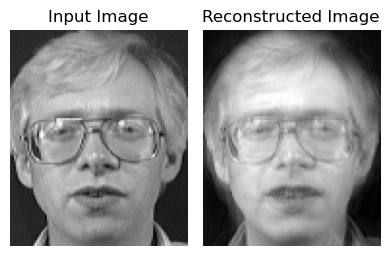

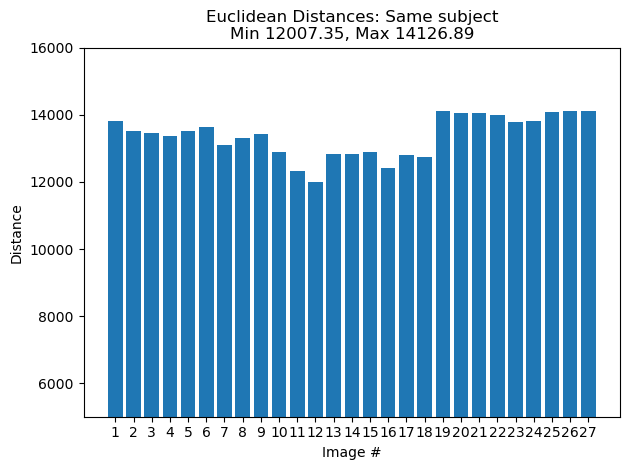

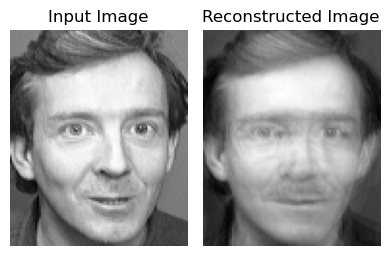

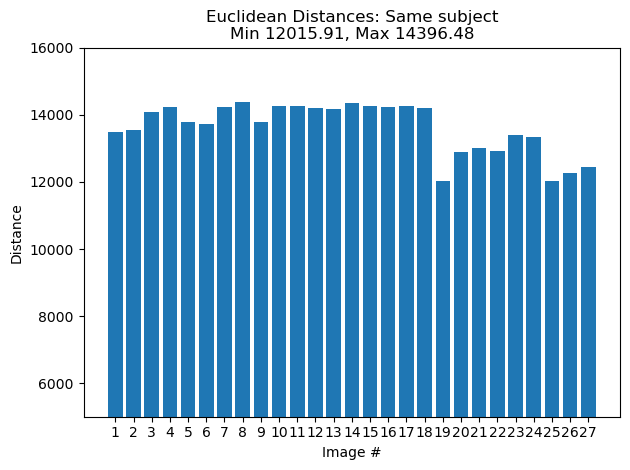

In [61]:
eSameSubjectsAll = []
for i in range(1,4):
    path = f'./ATT dataset/s{i}/'
    InputImage = imread(path + '10.pgm', as_gray=True)
    plt.figure(figsize=(4,4))

    plt.subplot(1,2,1)
    plt.imshow(InputImage, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference: NormalizedImage - MeanImage
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for j in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,j], NormImage) 
        p[j] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    # show the reconstructed image
    plt.subplot(1,2,2)
    plt.imshow(ReshapedImage, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()
    
    InImWeight = np.zeros((27,1))

    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        # scalar vector product of vectors t and Difference
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage
    
    eSameSubject = np.zeros((27,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eSameSubject[i] = mag
    eSameSubjectsAll.append(eSameSubject)
    # max/min Euclidean distance
    MaximumValue = np.max(eSameSubject) 
    MinimumValue = np.min(eSameSubject) 
       
    labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
          '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

    plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
    plt.ylim([5000, 16000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Euclidean Distances: Same subject\n'\
              'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))
    plt.show()
    

### Acquisition of probe image: 2 faces of the subjects not known to the dataset

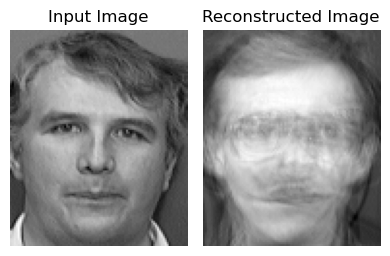

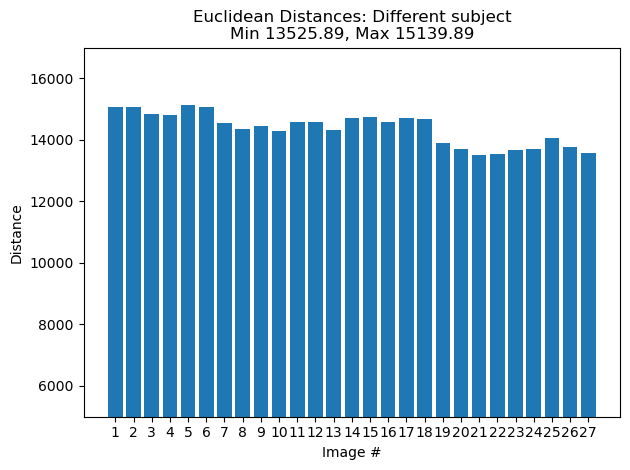

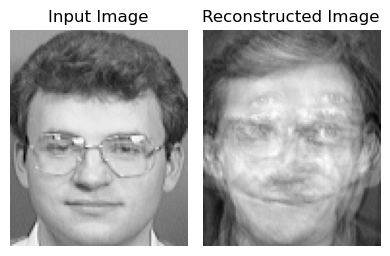

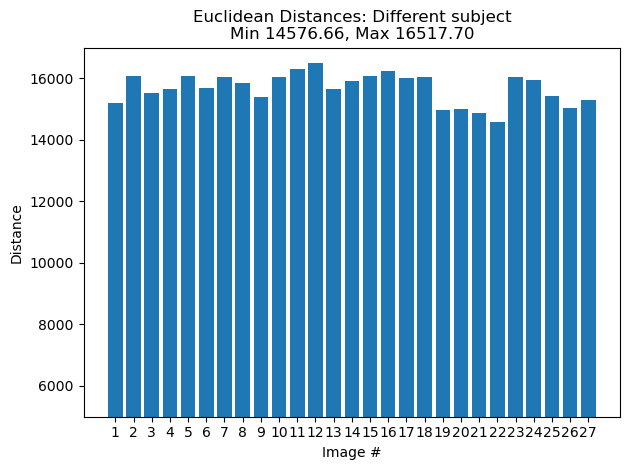

In [66]:
eDiffSubjectsAll = []
for i in [15,6]:
    path = f'./ATT dataset/s{i}/'
    InputImage = imread(path + '10.pgm', as_gray=True)

    plt.figure(figsize=(4,4))

    plt.subplot(1,2,1)
    plt.imshow(InputImage, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference: NormalizedImage - MeanImage
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for i in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,i], NormImage) 
        p[i] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    # show the reconstructed image
    plt.subplot(1,2,2)
    plt.imshow(ReshapedImage, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.show()
    
    InImWeight = np.zeros((27,1))

    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        # scalar vector product of vectors t and Difference
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage


    eDiffSubject = np.zeros((27,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eDiffSubject[i] = mag
    eDiffSubjectsAll.append(eDiffSubject)
    # max/min Euclidean distance
    MaximumValue = np.max(eDiffSubject) 
    MinimumValue = np.min(eDiffSubject)

    eDiffSubject = np.zeros((27,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eDiffSubject[i] = mag

    # max/min Euclidean distance
    MaximumValue = np.max(eDiffSubject) 
    MinimumValue = np.min(eDiffSubject) 


    labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
              '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

    plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
    plt.ylim([5000, 17000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Euclidean Distances: Different subject\n'\
              'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));
    
    plt.show()

## Acquisition of probe image: 1-2 Not a face image

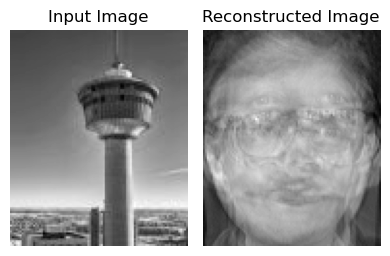

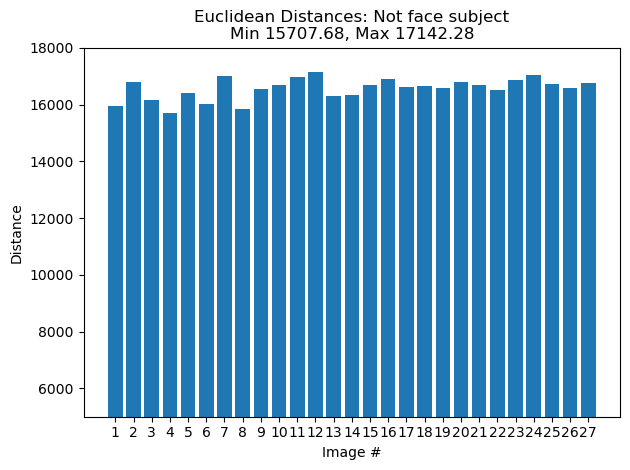

In [35]:
InputImage = imread('CalgaryTower.jpg', as_gray=True) 

plt.figure(figsize=(4,4))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

InImWeight = np.zeros((27,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage


eTower = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower)

eTower = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 


labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
          '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([5000, 18000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not face subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

plt.show()

We built a gallery of 27 images (first 9 images from subjects 1, 2, and 3), normalized them, and performed feature extraction as detailed in the lab instructions. 

We then performed matching for three 3 cases. The first case was a set of probe images that were already known to the gallery (the 10th image of subjects 1, 2 and 3). The minimum Euclidean distance for this classification was 12,007.35 (subject 2) and the maximum distance was 14,396.43 (subject 3). When looking at the bar plots for each match, it is clear that the 9 gallery images of the same subject as the probe image had a smaller distance than the remaining 18. 

The second case was comparing two probe images that were not known to the gallery (10th image of subjects 15 and 6). The min and max Euclidean distances of these matches were greater than the first case as they were of different people than the images in the gallery, indicating less similarity. The minimum Euclidean distance was 13,525.39 (subject 15) and the max was subject 6 (16,517.70).

The last cas was matching a non-face probe image with the gallery. We used an image of the Calgary Tower, and as it was not a human face, it resulted in the greatest Euclidean distances (the most difference out of the three cases) with a min of 15,707.68 and a max of 17,142.28. 

The min and max distances values for each match is shown above, along with a bar plot illustrating the distances of all 27 comparisons in each match.

# Exercise 2

In [96]:
# Set Threshold Values using max distance

print("Max distance from same probe images", round(np.max(eSameSubjectsAll),2))
print("Max distance from different probe images", round(np.max(eDiffSubjectsAll),2))
print("Max distance from non-face probe image", round(np.max(eTower),2),"\n")

threshold1 = np.max(eSameSubjectsAll)
threshold2 = np.max(eDiffSubjectsAll)
print('Inside Threshold',  round(np.max(eSameSubjectsAll),2))
print('Outside Threshold',  round(np.max(eDiffSubjectsAll),2))
print("\n")

distances = eSameSubjectsAll[0]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 1')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')
    
distances = eSameSubjectsAll[1]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 2')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 2')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 2')
    
distances = eSameSubjectsAll[2]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 3')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 3')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 3')
    
print('\n')
distances = eDiffSubjectsAll[0]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 15')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 15')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 15')

distances = eDiffSubjectsAll[1]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 6')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 6')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 6')
    
print('\n')
distances = eTower
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face, calgary tower')

Max distance from same probe images 14396.48
Max distance from different probe images 16517.7
Max distance from non-face probe image 17142.28 

Inside Threshold 14396.48
Outside Threshold 16517.7


Face is known to the dataset, subject 1
Face is known to the dataset, subject 2
Face is known to the dataset, subject 3


Face is known to the dataset, subject 15
Image is a face but not in the database, subject 6


Image is not a face, calgary tower


In [97]:
# Set Threshold Values using mean distance

print("Mean distance from same probe images", round(np.mean(eSameSubjectsAll),2))
print("Mean distance from different probe images", round(np.mean(eDiffSubjectsAll),2))
print("Mean distance from non-face probe image", round(np.mean(eTower),2),"\n")

threshold1 = np.mean(eSameSubjectsAll)
threshold2 = np.mean(eDiffSubjectsAll)
print('Inside Threshold',  round(np.mean(eSameSubjectsAll),2))
print('Outside Threshold',  round(np.mean(eDiffSubjectsAll),2))
print("\n")

distances = eSameSubjectsAll[0]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 1')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')
    
distances = eSameSubjectsAll[1]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 2')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 2')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 2')
    
distances = eSameSubjectsAll[2]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 3')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 3')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 3')
    
print('\n')
distances = eDiffSubjectsAll[0]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 15')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 15')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 15')

distances = eDiffSubjectsAll[1]
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Face is known to the dataset, subject 6')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database, subject 6')
elif (mean_of_distances > threshold2):
    print('Image is not a face, subject 6')
    
print('\n')
distances = eTower
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face, calgary tower')

Mean distance from same probe images 13455.52
Mean distance from different probe images 15031.58
Mean distance from non-face probe image 16565.29 

Inside Threshold 13455.52
Outside Threshold 15031.58


Face is known to the dataset, subject 1
Face is known to the dataset, subject 2
Image is a face but not in the database, subject 3


Image is a face but not in the database, subject 15
Image is not a face, subject 6


Image is not a face, calgary tower


#### Discussion
We determined and evaluated 2 sets of values for the inside and outside thresholds.

For the first set of values, we used the max distance of all Euclidean distances from the first two match cases in Ex 1. So, the inside threshold was the max distance from matching three probe images known to the dataset, and the outside threshold was the max distance from matching two probe images unknown to the dataset. For the results, we found that these thresholds produced 1 false positive as it classified subject 15 as known to the database when it should have been classified as "image is a face but not in the database".

We then used the mean distance of all Euclidean distances to set the thresholds in a similar way as described above. We found that now these thresholds produced 2 false negatives. It classified subject 3 as not in the database when it is known, and subject 6 as not a face when it is but not in the database.

Overall, for this procedure, using max distance to set the thresholds resulted in a classification with fewer false matches due to the less restrictive threshold values. However, this could in turn produce more false positives, which we could have observed if more probe images were matched against the gallery. The procedure of this lab could be improved by increasing the number of probe images compared to the gallery.

## Exercise 3:

In [105]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

In [106]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


In [107]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [108]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 200
Size of each sample: 10304


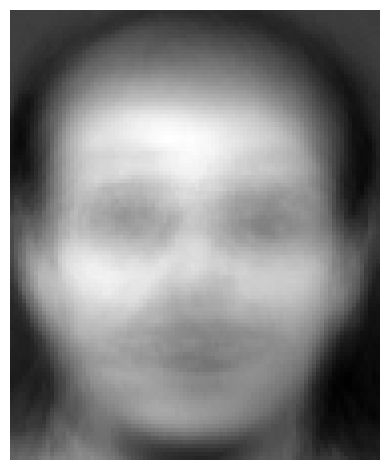

C:\Users\madhu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


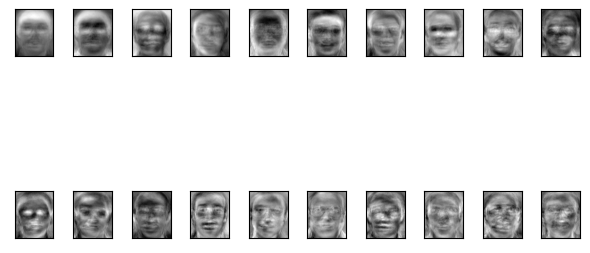

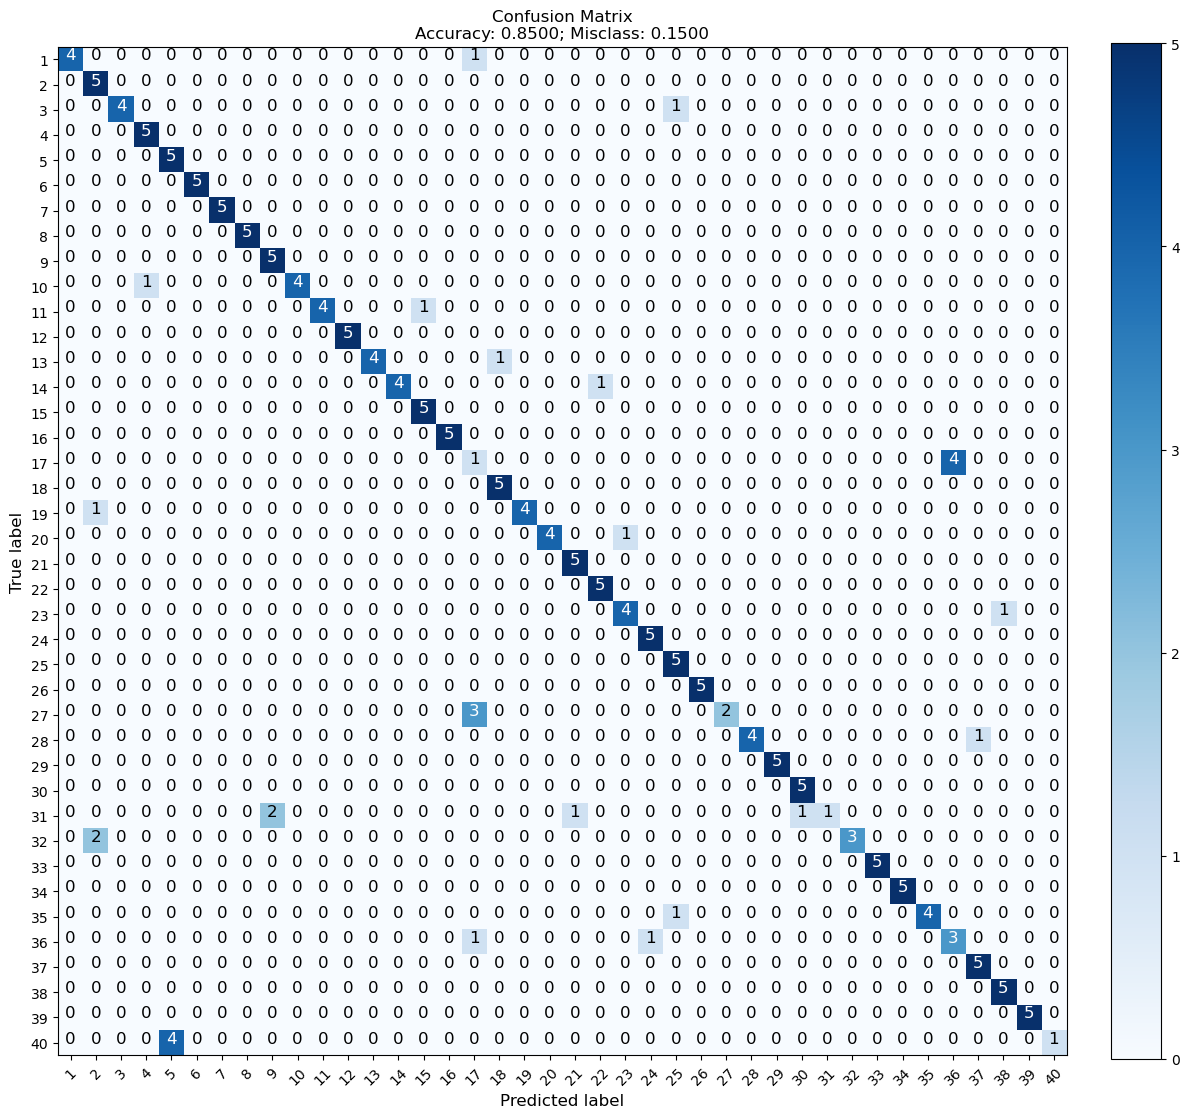

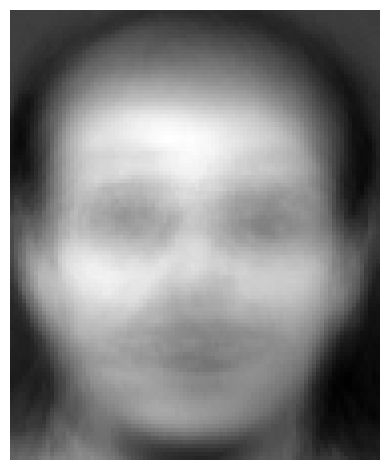

C:\Users\madhu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


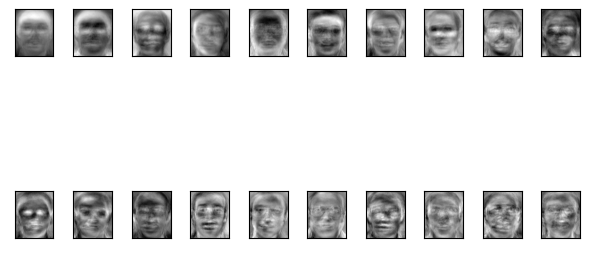

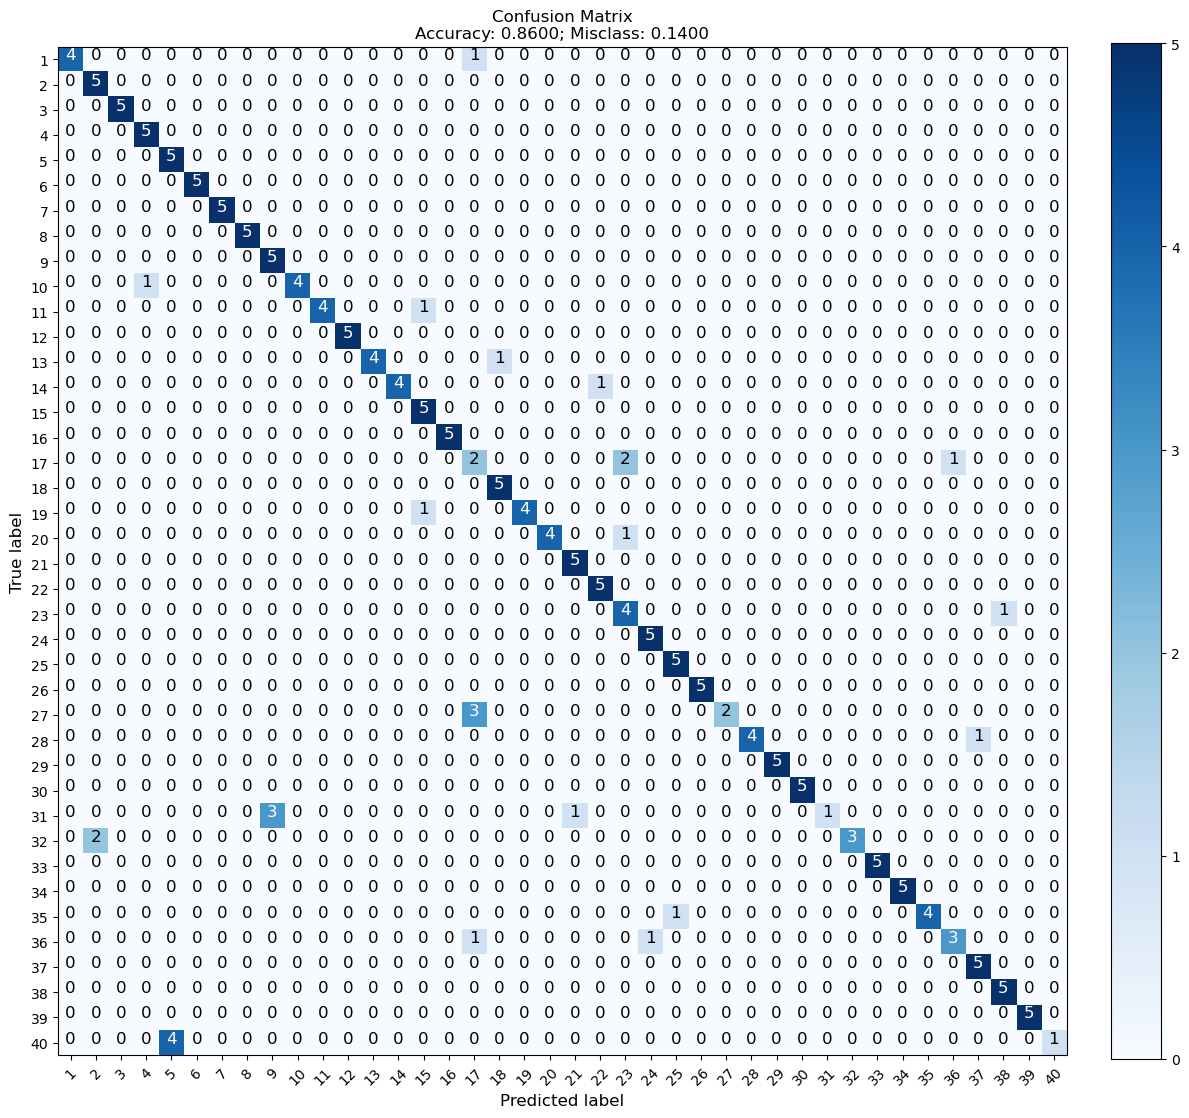

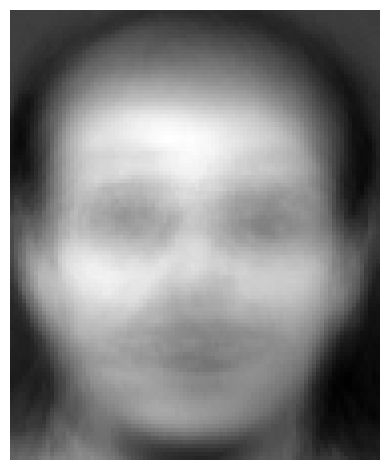

C:\Users\madhu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


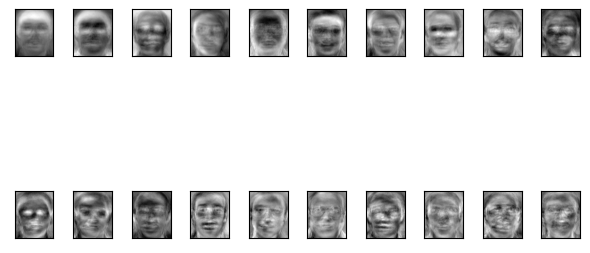

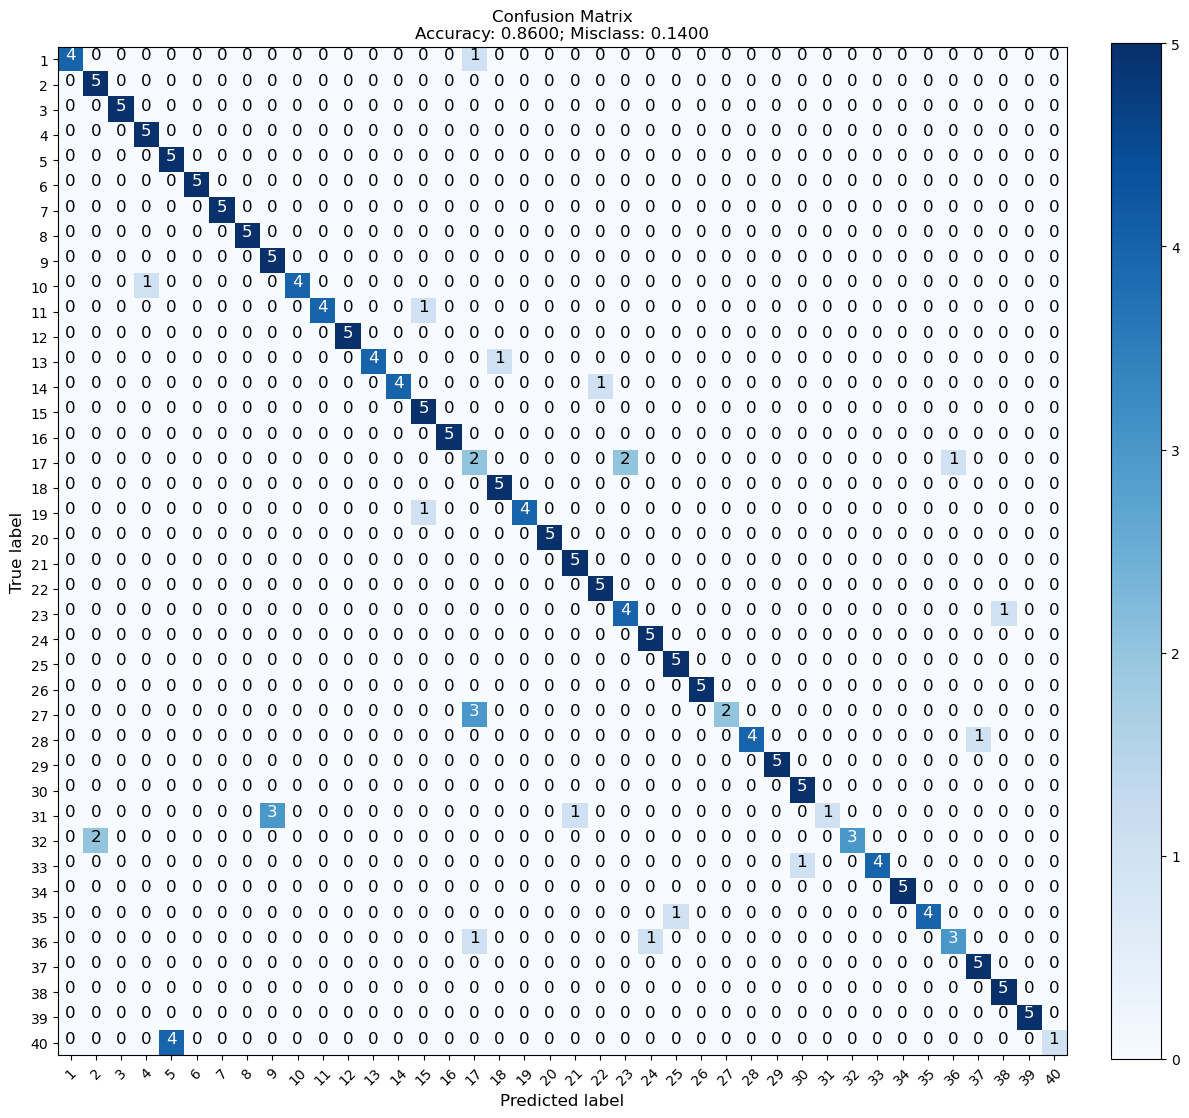

In [117]:
# n_components: number of principal components
n_components_options = [50,100,200]
truePredictions = {}
for n_components_pca in n_components_options:
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces)
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)
    plt.imshow(pca.mean_.reshape(img.shape))
    plt.axis('off');
    plt.show()
    fig = plt.figure(figsize=(6, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(img.shape))
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    prediction_evaluation(predictedLabels, testingLabels)
    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)
    trueCount = []
    for i in range(40):
        trueCount.append(confusionMatrix[i][i])
    truePredictions[n_components_pca] = trueCount
    
    plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

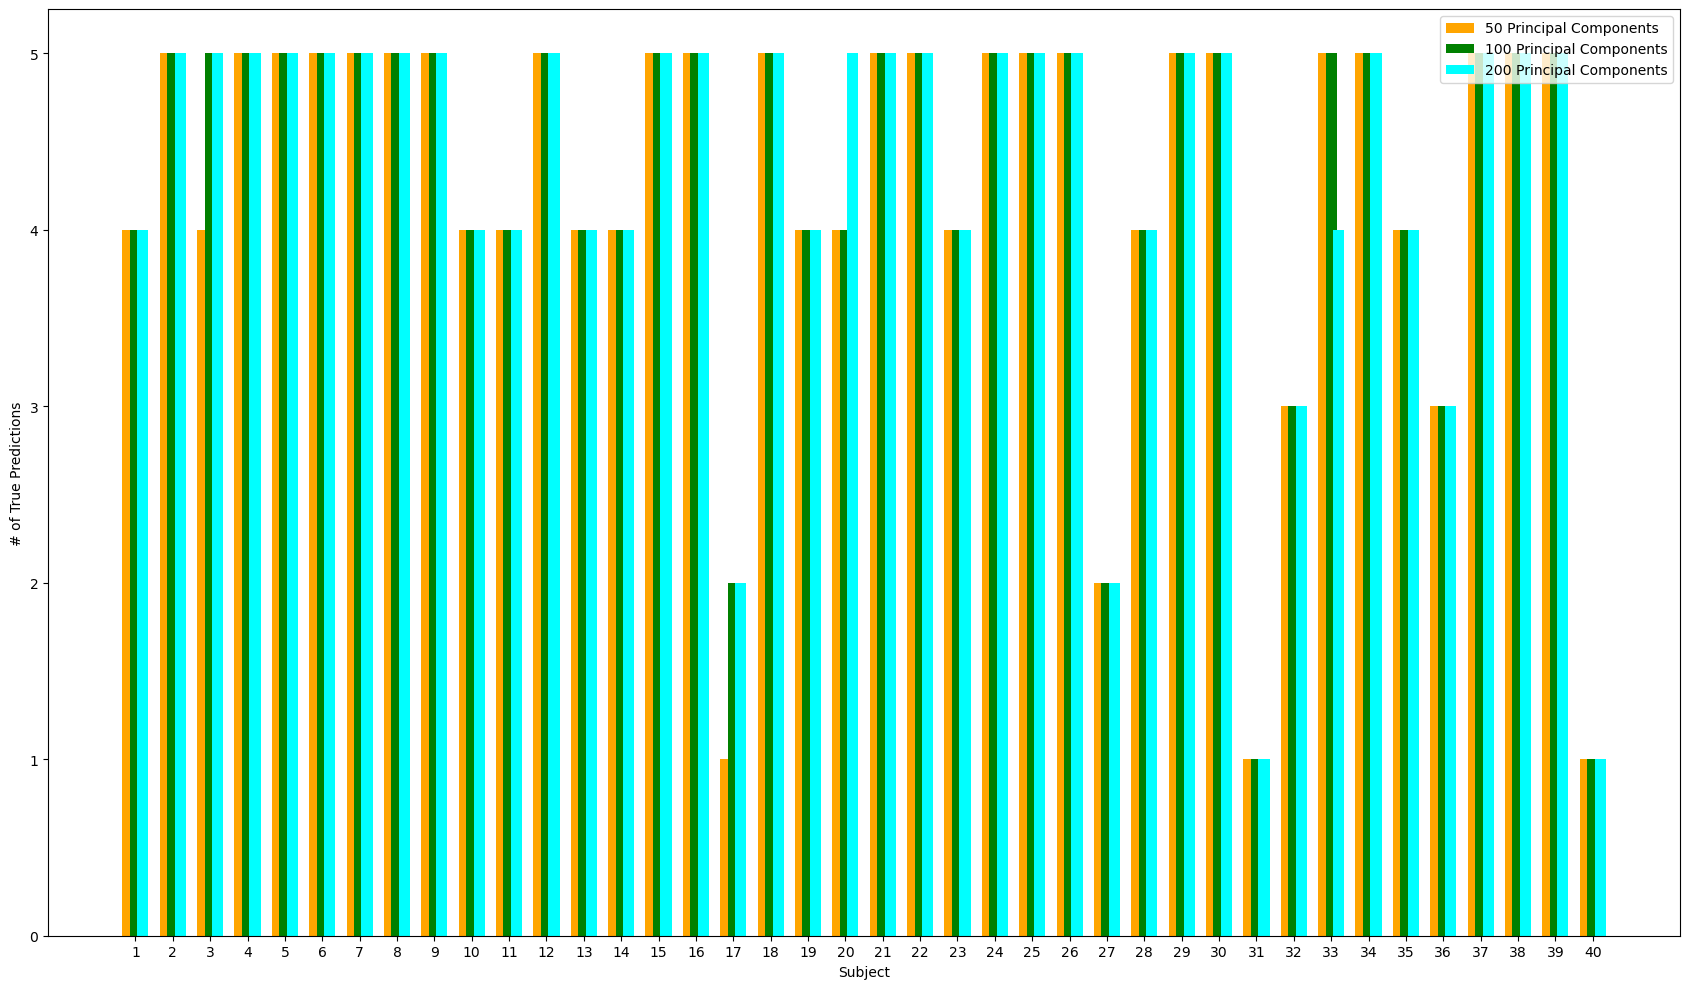

In [152]:
#plotting the number of true positives for each subject (grouped by # of principal components)
plt.figure(figsize=(17, 10))

X = np.arange(1,41)
plt.bar(X-0.2, truePredictions[50], 0.3, color = 'orange')
plt.bar(X, truePredictions[100], 0.3, color = 'green')
plt.bar(X+0.2, truePredictions[200], 0.3, color = 'cyan')


plt.legend(["50 Principal Components", "100 Principal Components", "200 Principal Components"])
plt.xlabel('Subject')
plt.ylabel('# of True Predictions')
plt.xticks(X)

plt.show()

#### Discussion

For this exercise, we did PCA and then used a KNN classifier. We set the number of subjects to be 40 (all subjects in the dataset provided), and for each subject, 5 images were used for training and 5 were used for testing. In total, we used 200 training faces.


| #Principal Components 	| Overall Accuracy (%) 	|
|-----------------------	|----------------------	|
| 50                    	| 85.0                 	|
| 100                   	| 86.0                 	|
| 200                   	| 86.0                 	|




We then evaluated three values for the number of principal components (50, 100, 200), and compared the resulting confusion matrix. 50 components resulted in an 85% overall accuracy while 100 and 200 components resulted in a slight increase to 86% accuracy. Comparing the confusion matrices between 50 and 100 components, we noticed that subject 17 went from 4 false predictions as subject 36, to 1 false prediction as subject 36, 1 as subject 23, and 1 as subject 24. So the number of correct predictions for subject 17 only increased from 1 to 2.

Looking at the bar chart, we see that the number of true predictions went up as the number of components increased for subjects 3, 17, and 20. But for subject 33, the number of true predictions decreased.

## Exercise 4:

In [43]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

number of knn_neighbors=5
For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]
Training faces: 160
Size of each sample: 10304


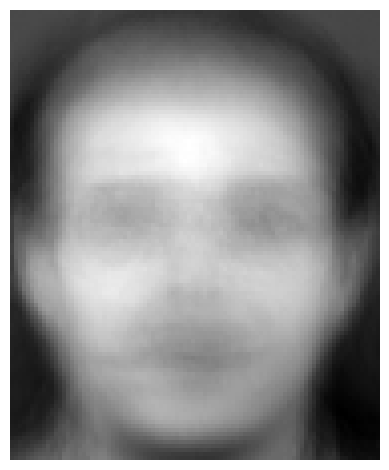

C:\Users\madhu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


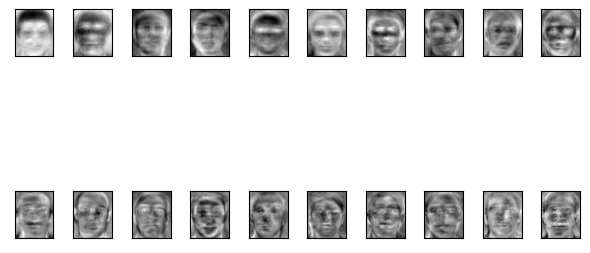

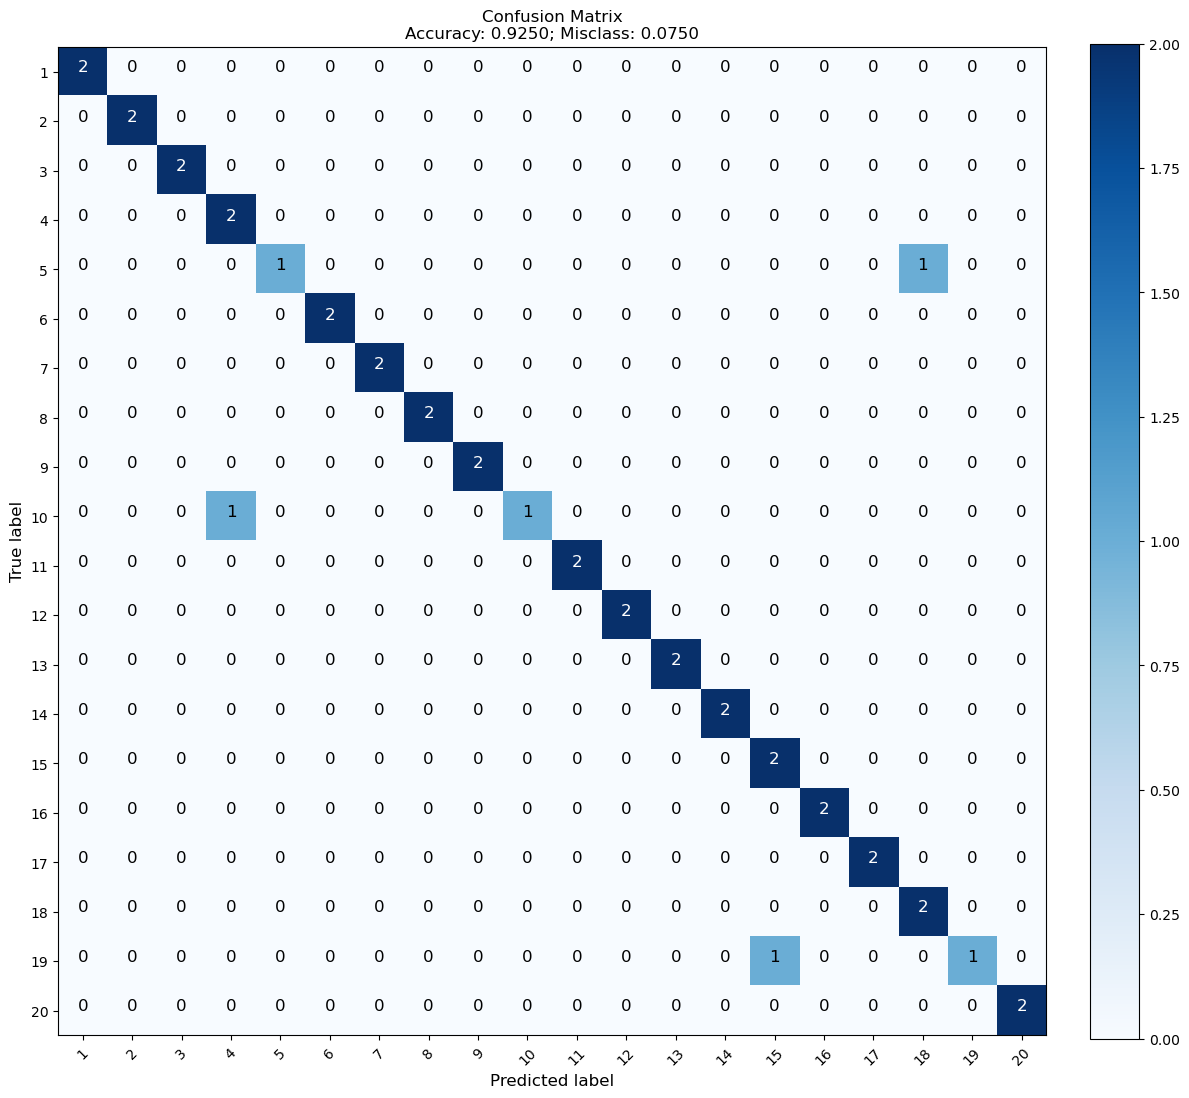

number of knn_neighbors=11
For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]
Training faces: 160
Size of each sample: 10304


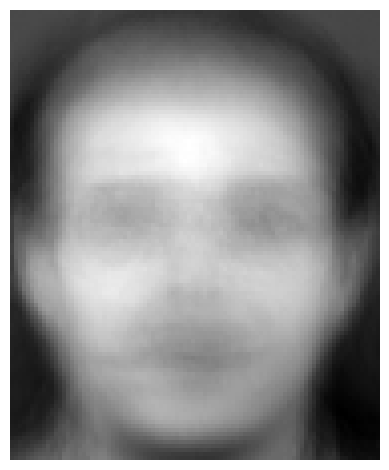

C:\Users\madhu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 77%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


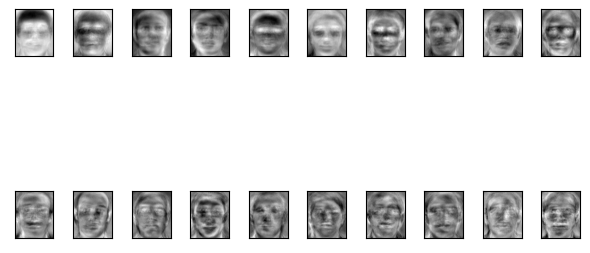

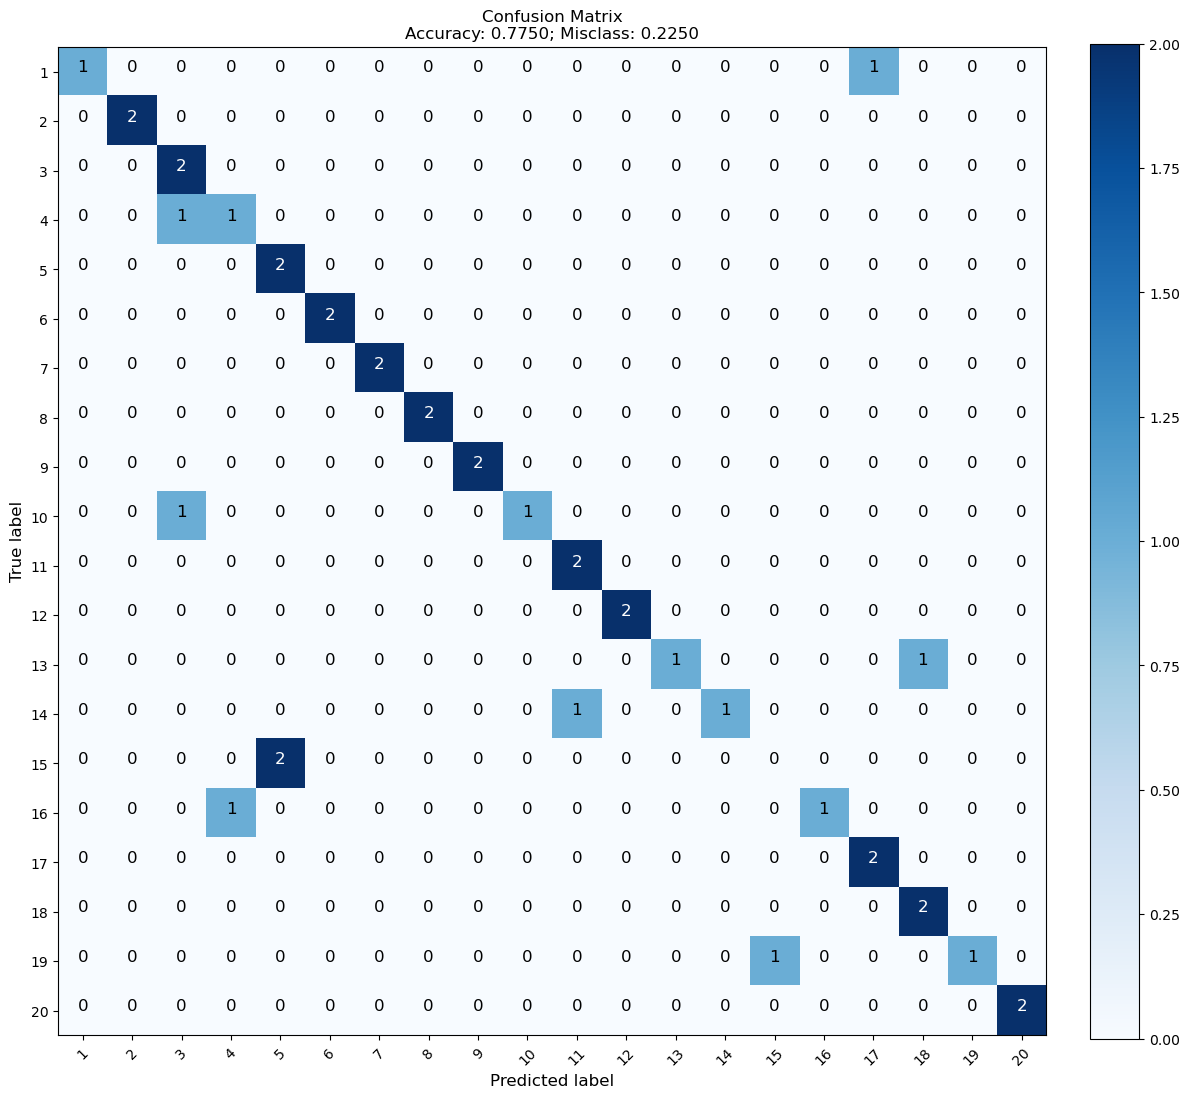

In [156]:
n_subjects = 20
truePredictionsKNN = {}
# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors_list = [5,11]
for knn_neighbors in knn_neighbors_list:
    print(f"number of knn_neighbors={knn_neighbors}")
    print('For EACH of all the %d subjects:' % (n_subjects))
    print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
    print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])
    
    # use the first 5 images from subjectID 1-n_subjects to train the classifier
    trainingFaces = []
    trainingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(1, n_training_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            trainingFaces.append(np.reshape(img, (img.size,)))
            trainingLabels.append(subjectId)

    # use the last 5 images from subjectID 1-20 to test the classifier
    testingFaces = []
    testingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            testingFaces.append(np.reshape(img, (img.size,)))
            testingLabels.append(subjectId)
            
    print('Training faces:', len(trainingFaces))
    print('Size of each sample:', len(trainingFaces[0]))  
    # n_components: number of principal components
    n_components_pca = 100
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces)
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)
    plt.imshow(pca.mean_.reshape(img.shape))
    plt.axis('off');
    plt.show()
    fig = plt.figure(figsize=(6, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(img.shape))
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    prediction_evaluation(predictedLabels, testingLabels)
    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)
    
    trueCount = []
    for i in range(20):
        trueCount.append(confusionMatrix[i][i])
    truePredictionsKNN[knn_neighbors] = trueCount
    
    plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

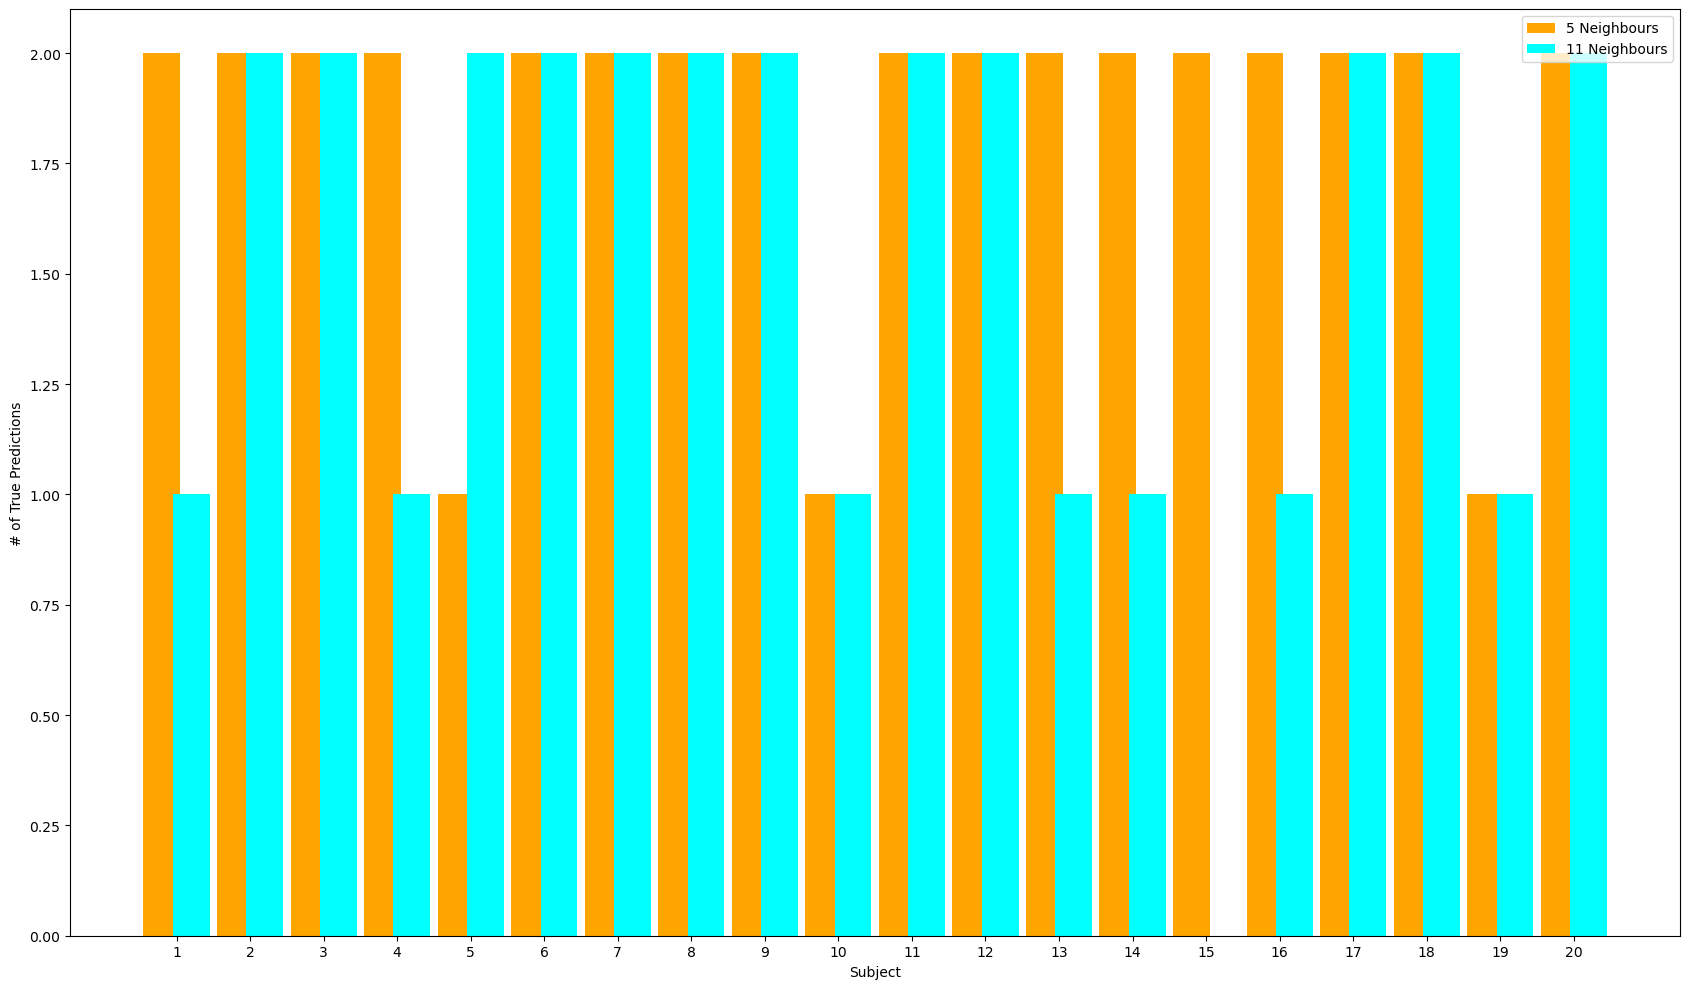

In [160]:
#plotting the number of true predictions for each of the 20 subjects (grouped by number of neighbours)
plt.figure(figsize=(17, 10))

X = np.arange(1,21)
plt.bar(X-0.2, truePredictionsKNN[5], 0.5, color = 'orange')
plt.bar(X+0.2, truePredictionsKNN[11], 0.5, color = 'cyan')


plt.legend(["5 Neighbours", "11 Neighbours"])
plt.xlabel('Subject')
plt.ylabel('# of True Predictions')
plt.xticks(X)

plt.show()

For this exercise we observed how the number of neighbours affects the accuracy of a KNN classifier. We used 20 subjects, 8 images for training, and 8 for testing.


| #Neighbours 	| Overall Accuracy (%) 	|
|-------------	|----------------------	|
| 5           	| 92.5                 	|
| 11          	| 80.0                 	|


Using 5 neighbours produced a higher accuracy of 92.5% compared to 80.0% for 11 neighbours. Comparing the confusion matrices, one observation is that subject 15 was affected the most as it went from 2 true predictions with 5 neighbours to 2 false predictions with 11 neighbours.

Looking at the bar chart, we observe that increasing the number of neighbours to 11 decreased the number of true predictions for subjects 1, 4, 13, 14, 15, and 16. However for subject 5, the number of true predictions increased. 

# Conclusion

In this lab, we found that probe images known to the image result in a smaller Euclidean distance measurement, and that using the max distance as the classification threshold results in some false positives while using the mean distance is too restrictive and results in false negatives. 

then, after modifying the number of principal components when doing PCA, we found that the accuracy of the KNN model increased by only 1% when the number of components went from 50 to 100, but there was no change when modified from 100 to 200. Overall, increasing the number of components does not have a major effect on classifier accuracy. 

Finally, we found that the number of neighbors has a more significant impact on KNN accuracy, as 11 neighbors resulted in a lower accuracy score (85%) compared to 5 neighbors (92.5%).